For the following analysis of the data to work properly, when calling read_and_manipulate_data, please input
a CSV file with the following columns:

date, state, fips, cases, deaths

Where each is defined as follows:
date (string): Date data was recorded (yyyy - mm - dd)
state (String): State from which data is recorded
fips (integer): A code provided by the American National Standards Institute (ANSI) assigning a numerical code to each US State/terriroty
cases (integer): The total number of cases of Covid-19, including both confirmed and probable.
deaths (integer): The total number of deaths from Covid-19, including both confirmed and probable.

Possible improvements:
7 day rolling average is still hard coded
(Maybe, idk): Instead of having user call read_and_manipulate_data, make these calls within all of the functions and add file name as an argument
Raise an error message if the user gives an improperly formatted csv file into read_and_manipulate_data
Figure out where to document the possible errors in the NYT data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
import math

In [2]:
# Requires: filename to be a properly formated (specified above) CSV file
# Ensures: A dataframe of the proper formatting for further functions
def read_and_manipulate_data(filename):
    
    df = pd.read_csv(filename)
    
    # Manipulation of covid dataset below
    
    # Convert type of elements in date column from string to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort covid data set by fips (ascending numerically) and date (chronologically)
    df = df.sort_values(["fips", "date"])

    # Creates new columns for cases and deaths per day in covid dataset
    # First, makes groups of each state
    # Then subtracts each value for cases/states by the previous date (NaN if first date for state)
    df['new_cases_per_day'] = df.groupby(["state"])['cases'].diff()
    df['new_deaths_per_day'] = df.groupby(["state"])['deaths'].diff()

    # Creates new columns for 7 day rolling average of cases/deaths
    df['new_cases_7ra'] = df['new_cases_per_day'].rolling(7).mean()
    df['new_deaths_7ra'] = df['new_deaths_per_day'].rolling(7).mean()
    return df

In [3]:
# Requires: df to be properly formatted
def plot_new_cases_vs_deaths(df, x = 15, y = 10,font = 25, rotate = True, alpha_val = 0.7):
    fig, ax = plt.subplots(figsize = (x, y))

    plt.plot(df['new_deaths_per_day'], df['new_cases_per_day'], 'o', alpha = alpha_val)

    plt.xlabel('New deaths', fontsize = font)
    
    if(rotate):
        plt.xticks(rotation = 90)

    plt.ylabel('New cases', fontsize = font)

In [4]:
# Requires: df to be properly formatted
def plot_new_deaths_vs_state(df, x = 15, y = 10,font = 25, rotate = True, alpha_val = 0.7):
    fig, ax = plt.subplots(figsize = (x, y))
    plt.plot(df['state'], df['new_deaths_per_day'], 'o', alpha = alpha_val)

    plt.xlabel('State', fontsize = font)
    
    if(rotate):
        plt.xticks(rotation = 90)

    plt.ylabel('New deaths', fontsize = font)

In [5]:
# Requires: df to be properly formatted
def plot_new_cases_vs_state(df, x = 15, y = 10, font = 25, rotate = True, alpha_val = 0.7):
    fig, ax = plt.subplots(figsize = (x, y))
    plt.plot(df['state'], df['new_cases_per_day'], 'o', alpha = alpha_val)

    plt.xlabel('State', fontsize = font)
    
    if(rotate):
        plt.xticks(rotation = 90)
        
    plt.ylabel('New cases', fontsize = font)

In [6]:
# Intialize function to plot new cases per day with given dataframe and state
# User input: Dataframe, state
# Optional arguments:
#    x (width, default 15), y (height, default 10), font (fontsize, default 25), alpha_val (transparency, default 0.9)
#    legend_font (legend font size, default 10)

# Requires: df to be properly formatted and state to be a valid US state
def plot_new_cases(df, state, x = 15, y = 10, font = 25, alpha_val = 0.9, legend_font = 10):
    fig, ax = plt.subplots(figsize = (x, y))
    
    # Makes another dataframe containing only the state from the input
    state_df = df[df['state'] == state]
    
    # Plots new cases per day of given state
    plt.plot(state_df['date'], state_df['new_cases_per_day'], alpha = alpha_val, label = 'New cases')
    # Plots new cases per day of given state (7 day rolling average)
    plt.plot(state_df['date'], state_df['new_cases_7ra'], alpha = alpha_val, label = '7 day rolling average of new cases')
    
    plt.xlabel('Dates', fontsize = font)
    plt.ylabel('New Cases', fontsize = font)
    plt.title('New Cases vs Date in {}'.format(state), fontsize = font)
    plt.legend(fontsize = legend_font)

In [7]:
# Intialize function to plot new deaths per day with given dataframe and state
# User input: Dataframe, state
# Optional arguments:
#    x (width, default 15), y (height, default 10), font (fontsize, default 25), alpha_val (transparency, default 0.9)
#    legend_font (legend font size, default 10)

# Requires: Properly formatted dataframe and valid State
def plot_new_deaths(df, state, x = 15, y = 10, font = 25, alpha_val = 0.9, legend_font = 10):
    fig, ax = plt.subplots(figsize = (x, y))
    
    # Makes another dataframe containing only the state from the input
    state_df = df[df['state'] == state]
    
    # Plots new deaths per day of given state
    plt.plot(state_df['date'], state_df['new_deaths_per_day'], alpha = alpha_val, label = 'New deaths')
    # Plots new deaths per day of given state (7 day rolling average)
    plt.plot(state_df['date'], state_df['new_deaths_7ra'], alpha = alpha_val, label = '7 day rolling average of new deaths')
    
    plt.xlabel('Dates', fontsize = font)
    plt.ylabel('New Deaths', fontsize = font)
    plt.title('New Deaths vs Date in {}'.format(state), fontsize = font)
    plt.legend(fontsize = legend_font)

In [8]:
def plot_normalized_cases(df, state_list, census_data = "2019_US_Pop.csv", pop_normal = 10000, death_threshold = 5, x = 15, y = 10, font = 25, alpha_val = 0.9, legend_font = 10, log = False):
    fig, ax = plt.subplots(figsize = (x, y))
    
    # Only keeps datapoints for when each state has hit "outbreak" levels
    df = df[df['deaths'] > death_threshold]
    
    for state in state_list:
        # Makes another dataframe containing only the state from the for loop
        state_df = df[df['state'] == state]
        
        # Initialize days_since_outbreak to 1 so we can call cumsum()
        state_df['days_since_death_threshold'] = 1
        # 0th day issues? All days_since_outbreak may be off by one day??
        state_df['days_since_death_threshold'] = state_df['days_since_death_threshold'].cumsum()
        

        # Extract census population estimates
        states = pd.read_csv(census_data)
        
        # Gets state and population df of just one state
        target_state = states[states['State'] == state]
        
        # Gets the population series of that one state
        s = target_state['Population']
        
        # Extracts the scalar value from the population series
        target_population = s.item()

        new_col_name = str(state) + ' cases per ' + str(pop_normal)
        state_df[new_col_name] = state_df['cases'] / target_population * pop_normal

        # Plots new deaths per day of given state
        if(log):
            plt.plot(state_df['days_since_death_threshold'], np.log(state_df[new_col_name]), alpha = alpha_val, label = new_col_name)
        else:
            plt.plot(state_df['days_since_death_threshold'], state_df[new_col_name], alpha = alpha_val, label = new_col_name)
    
    plt.xlabel('Days since death threshold (' + str(death_threshold) + ' deaths)', fontsize = font)
    
    if(log):
        plt.ylabel('Log of cases per ' + str(pop_normal) + ' people', fontsize = font)
    else:
        plt.ylabel('Cases per ' + str(pop_normal) + ' people', fontsize = font)
    plt.legend(fontsize = legend_font)


In [9]:
t = pd.read_csv("2019_US_Pop.csv")
# print(t.loc[0])
t = t.set_index('State')
# print(t.loc["Alabama"])
t.loc["Alabama"]["Population"]

4903185

In [10]:
'''t.iat[0,0]

.loc
.iloc
.iat
'''

't.iat[0,0]\n\n.loc\n.iloc\n.iat\n'

In [11]:
help(t.iat)

Help on _iAtIndexer in module pandas.core.indexing object:

class _iAtIndexer(_ScalarAccessIndexer)
 |  Access a single value for a row/column pair by integer position.
 |  
 |  Similar to ``iloc``, in that both provide integer-based lookups. Use
 |  ``iat`` if you only need to get or set a single value in a DataFrame
 |  or Series.
 |  
 |  Raises
 |  ------
 |  IndexError
 |      When integer position is out of bounds.
 |  
 |  See Also
 |  --------
 |  DataFrame.at : Access a single value for a row/column label pair.
 |  DataFrame.loc : Access a group of rows and columns by label(s).
 |  DataFrame.iloc : Access a group of rows and columns by integer position(s).
 |  
 |  Examples
 |  --------
 |  >>> df = pd.DataFrame([[0, 2, 3], [0, 4, 1], [10, 20, 30]],
 |  ...                   columns=['A', 'B', 'C'])
 |  >>> df
 |      A   B   C
 |  0   0   2   3
 |  1   0   4   1
 |  2  10  20  30
 |  
 |  Get value at specified row/column pair
 |  
 |  >>> df.iat[1, 2]
 |  1
 |  
 |  Set valu

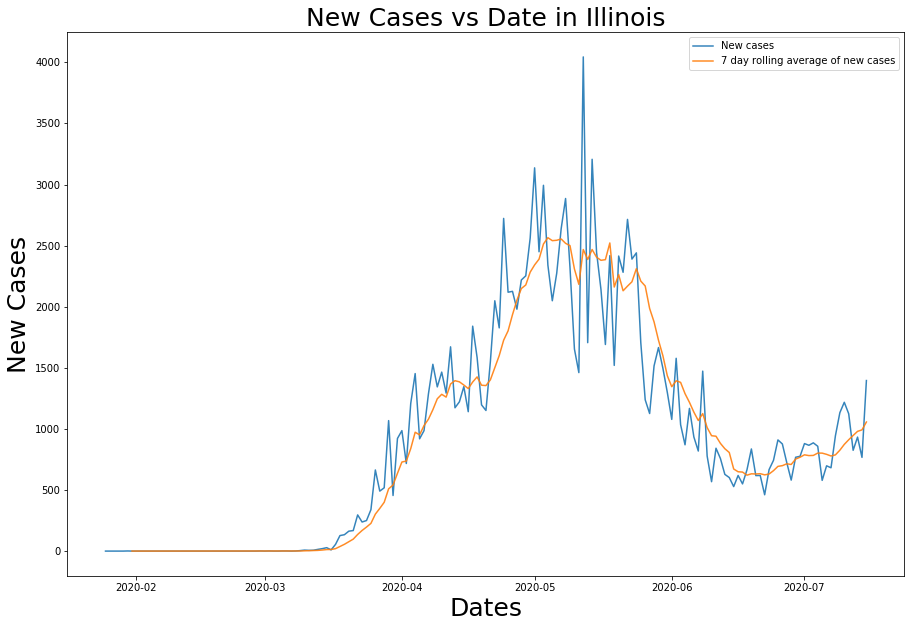

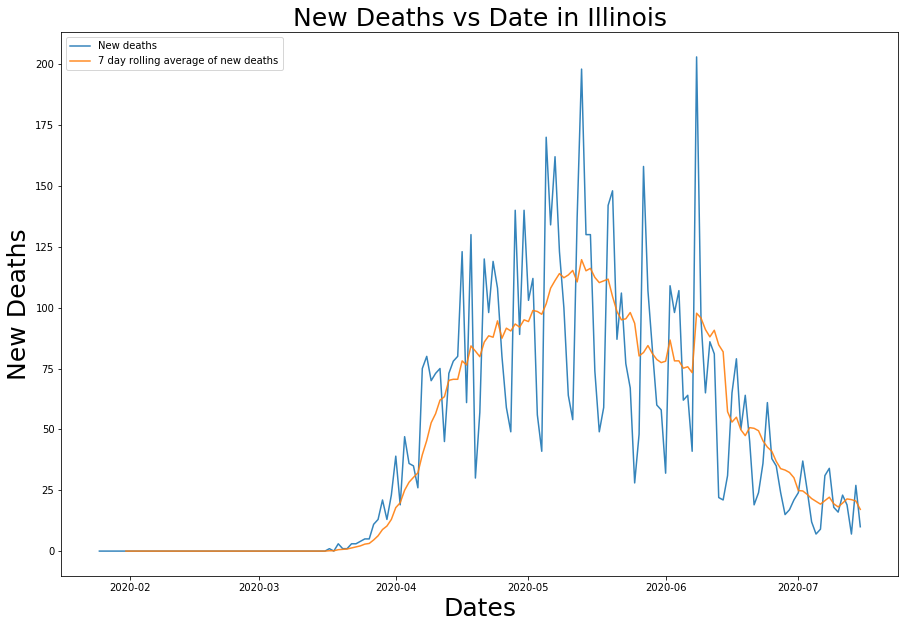

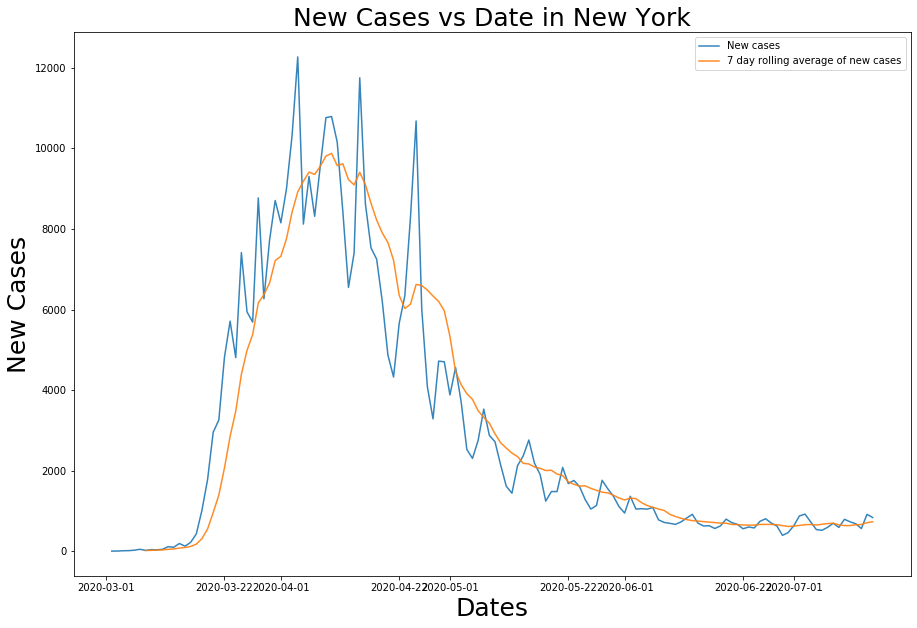

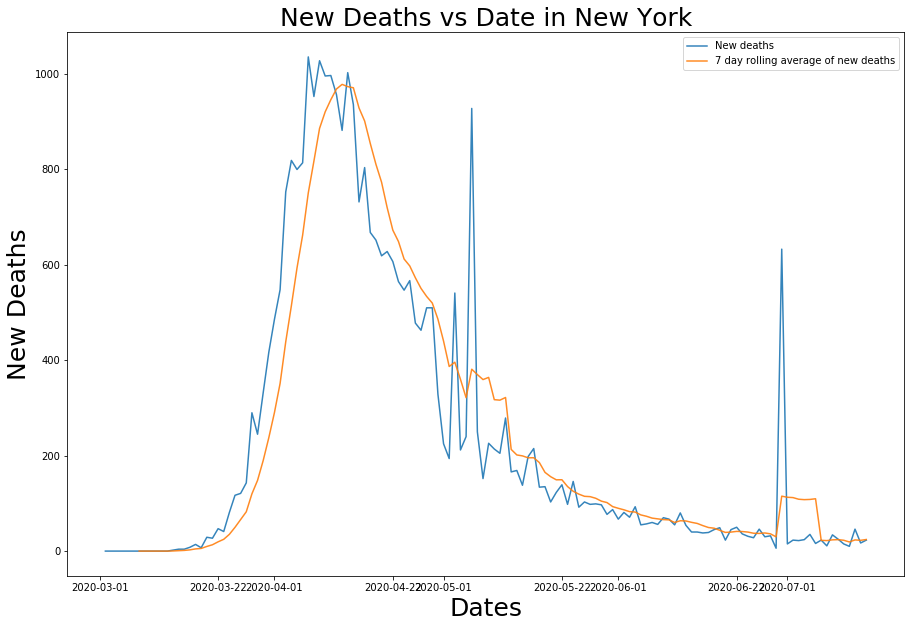

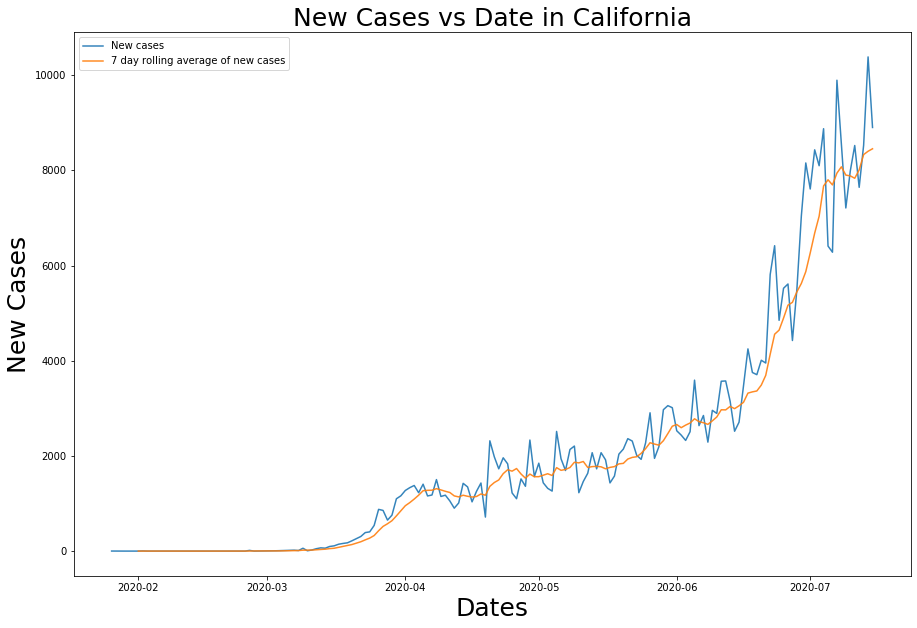

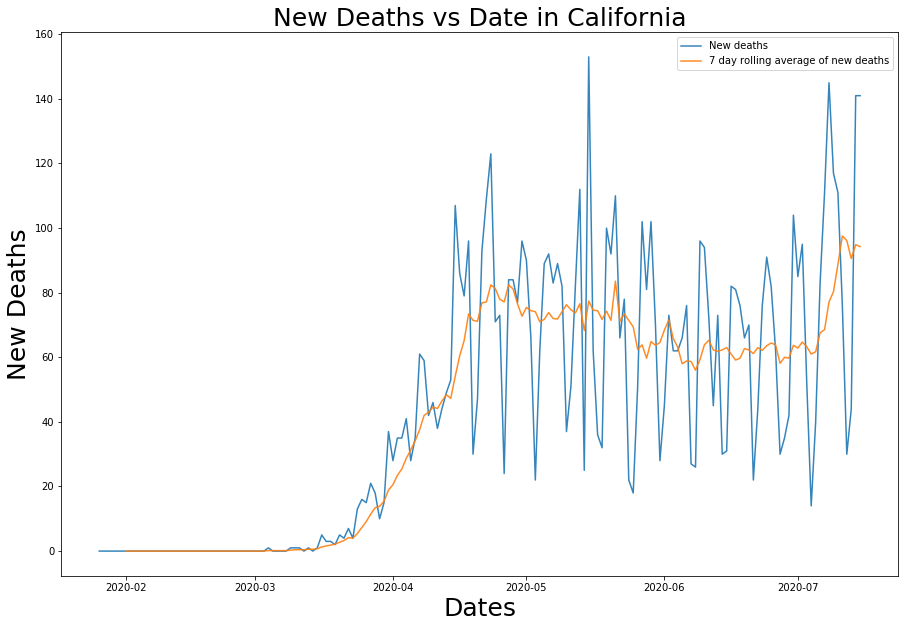

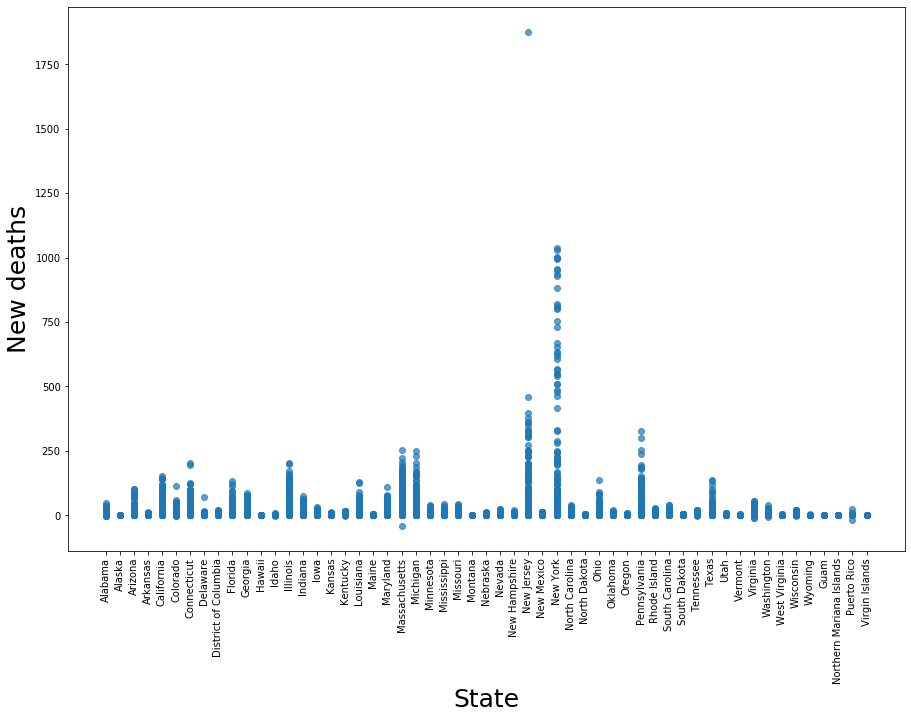

In [12]:
# Below is all calls to previously defined functions
# Begin with a call to read_and_manipulate_data
covid = read_and_manipulate_data("us-states.csv")
plot_new_cases(covid, 'Illinois')
plot_new_deaths(covid, 'Illinois')
plot_new_cases(covid, 'New York')
plot_new_deaths(covid, 'New York')
plot_new_cases(covid, 'California')
plot_new_deaths(covid, 'California')
plot_new_deaths_vs_state(covid)

In [13]:
states = pd.read_csv("2019_US_Pop.csv")
print(states)

                   State  Population
0                Alabama     4903185
1                 Alaska      731545
2                Arizona     7278717
3               Arkansas     3017804
4             California    39512223
5               Colorado     5758736
6            Connecticut     3565287
7               Delaware      973764
8   District of Columbia      705749
9                Florida    21477737
10               Georgia    10617423
11                Hawaii     1415872
12                 Idaho     1787065
13              Illinois    12671821
14               Indiana     6732219
15                  Iowa     3155070
16                Kansas     2913314
17              Kentucky     4467673
18             Louisiana     4648794
19                 Maine     1344212
20              Maryland     6045680
21         Massachusetts     6892503
22              Michigan     9986857
23             Minnesota     5639632
24           Mississippi     2976149
25              Missouri     6137428
2

In [15]:
#pd.options.mode.chained_assignment = "warn"
pd.options.mode.chained_assignment = None

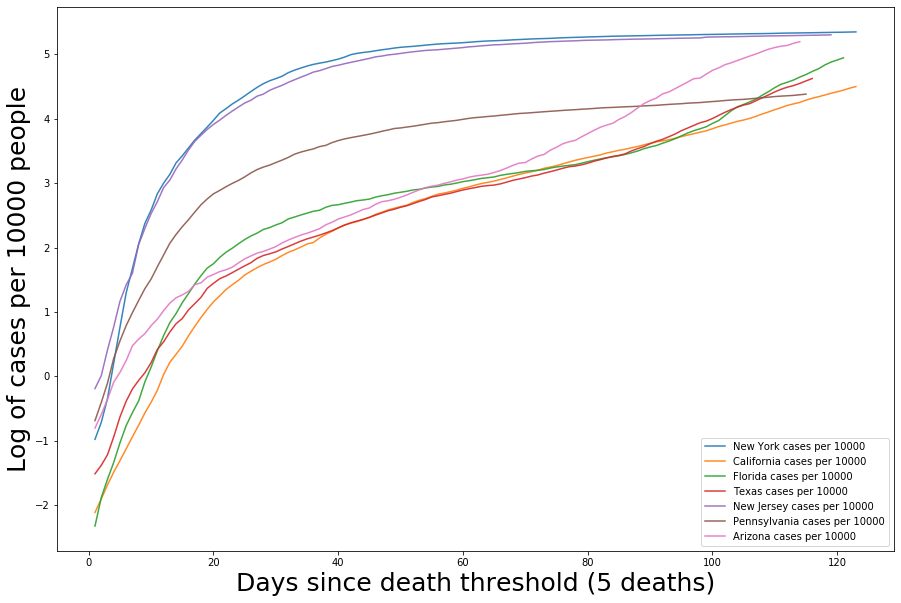

In [16]:
covid = read_and_manipulate_data("us-states.csv")
states = ["New York", "California", "Florida", "Texas","New Jersey","Pennsylvania","Arizona"]

plot_normalized_cases(covid,states, log = True)


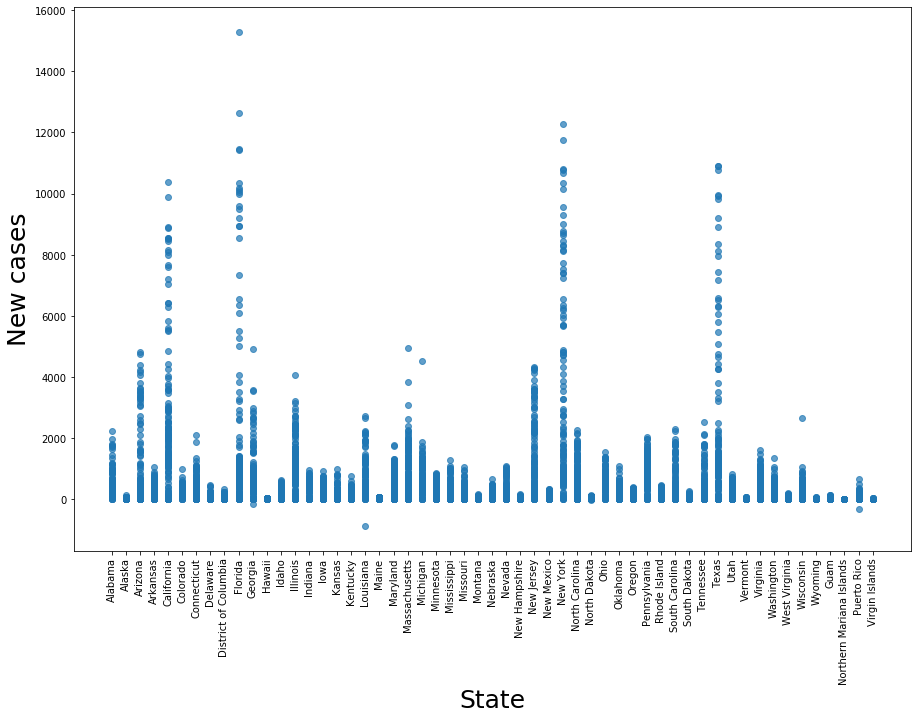

In [17]:
plot_new_cases_vs_state(covid)

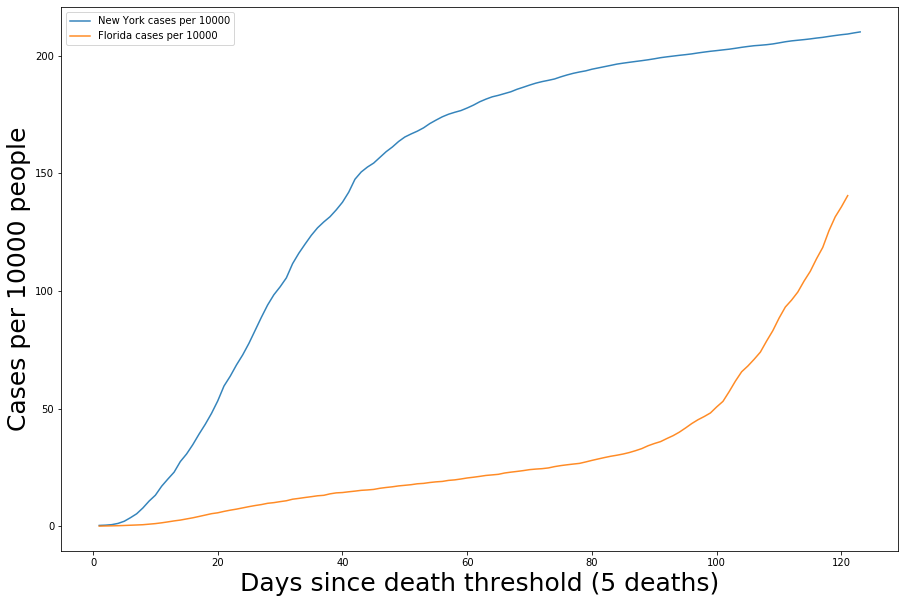

In [18]:
covid = read_and_manipulate_data("us-states.csv")
plot_normalized_cases(covid,["New York","Florida"])